In [1]:
# !pip install yfinance pandas_ta stockstats transformers torch plotly

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import pandas_ta as ta
from stockstats import StockDataFrame
# Optional (for LLM/news sentiment)
from transformers import pipeline


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- User Inputs ---
ticker_symbol = 'AAPL'  # change ticker as needed
# Download price/volume data
data = yf.download(ticker_symbol, period='2y', auto_adjust=True)
info = yf.Ticker(ticker_symbol).info
stock = yf.Ticker(ticker_symbol)


[*********************100%***********************]  1 of 1 completed


In [3]:
# In case of MultiIndex, flatten columns
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join(col).strip() for col in data.columns]


5.1 Snapshot Table

In [4]:
metrics = {
    "Ticker": ticker_symbol,
    "Sector": info.get('sector'),
    "Industry": info.get('industry'),
    "Market Cap": info.get('marketCap'),
    "P/E Ratio": info.get('trailingPE'),
    "P/B Ratio": info.get('priceToBook'),
    "Dividend Yield": info.get('dividendYield'),
    "Revenue (TTM)": info.get('totalRevenue'),
    "Net Income (TTM)": info.get('netIncomeToCommon'),
    "Debt": info.get('totalDebt'),
    "Cash": info.get('totalCash'),
    "ROE": info.get('returnOnEquity'),
}
display(pd.DataFrame(metrics, index=[0]).T)


,0
Ticker,AAPL
Sector,Technology
Industry,Consumer Electronics
Market Cap,3154142035968
P/E Ratio,32.89408
P/B Ratio,47.233276
Dividend Yield,0.51
Revenue (TTM),400366010368
Net Income (TTM),97294000128
Debt,98186002432


5.2 Key Financials (Income, Balance, Cash Flow)

In [5]:
fin = stock.financials.T
bal = stock.balance_sheet.T
cf = stock.cashflow.T

# Show last four years trending
fin['Revenue Growth %'] = fin['Total Revenue'].pct_change() * 100
fin['Net Income Growth %'] = fin['Net Income'].pct_change() * 100
display(fin[['Total Revenue', 'Revenue Growth %', 'Net Income', 'Net Income Growth %']].tail(4))


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21840\3030953164.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  fin['Revenue Growth %'] = fin['Total Revenue'].pct_change() * 100
C:\Users\ASUS\AppData\Local\Temp\ipykernel_21840\3030953164.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  fin['Net Income Growth %'] = fin['Net Income'].pct_change() * 100


,Total Revenue,Revenue Growth %,Net Income,Net Income Growth %
2023-09-30,3.832850e+11,-1.981920,9.699500e+10,3.476786
2022-09-30,3.943280e+11,2.881146,9.980300e+10,2.894995
2021-09-30,3.658170e+11,-7.230275,9.468000e+10,-5.133112
2020-09-30,NaN,0.000000,NaN,0.000000


5.3 Margins, Liquidity, Solvency

In [6]:
# Gross & Operating Margin
try:
    print("Gross Margin:", f"{info.get('grossMargins'):.2%}")
    print("Operating Margin:", f"{info.get('operatingMargins'):.2%}")
except:
    pass

# Current & Quick Ratios
try:
    current_ratio = bal['Total Current Assets'].iloc[-1] / bal['Total Current Liabilities'].iloc[-1]
    quick_ratio = (bal['Total Current Assets'].iloc[-1] - bal['Inventory'].iloc[-1]) / bal['Total Current Liabilities'].iloc[-1]
    print(f"Current Ratio: {current_ratio:.2f}")
    print(f"Quick Ratio: {quick_ratio:.2f}")
except:
    print("Liquidity ratios: N/A")


Gross Margin: 46.63%
Operating Margin: 31.03%
Liquidity ratios: N/A


5.4 Cash Flow Trends
python

In [7]:
cf.head

<bound method NDFrame.head of             Free Cash Flow  Repurchase Of Capital Stock  Repayment Of Debt  \
2024-09-30    1.088070e+11                -9.494900e+10      -9.958000e+09   
2023-09-30    9.958400e+10                -7.755000e+10      -1.115100e+10   
2022-09-30    1.114430e+11                -8.940200e+10      -9.543000e+09   
2021-09-30    9.295300e+10                -8.597100e+10      -8.750000e+09   
2020-09-30             NaN                          NaN                NaN   

            Issuance Of Debt  Issuance Of Capital Stock  Capital Expenditure  \
2024-09-30      0.000000e+00                        NaN        -9.447000e+09   
2023-09-30      5.228000e+09                        NaN        -1.095900e+10   
2022-09-30      5.465000e+09                        NaN        -1.070800e+10   
2021-09-30      2.039300e+10               1.105000e+09        -1.108500e+10   
2020-09-30               NaN               8.800000e+08                  NaN   

            Interest

In [9]:
cf.columns

Index(['Free Cash Flow', 'Repurchase Of Capital Stock', 'Repayment Of Debt',
       'Issuance Of Debt', 'Issuance Of Capital Stock', 'Capital Expenditure',
       'Interest Paid Supplemental Data', 'Income Tax Paid Supplemental Data',
       'End Cash Position', 'Beginning Cash Position', 'Changes In Cash',
       'Financing Cash Flow', 'Cash Flow From Continuing Financing Activities',
       'Net Other Financing Charges', 'Cash Dividends Paid',
       'Common Stock Dividend Paid', 'Net Common Stock Issuance',
       'Common Stock Payments', 'Common Stock Issuance',
       'Net Issuance Payments Of Debt', 'Net Short Term Debt Issuance',
       'Net Long Term Debt Issuance', 'Long Term Debt Payments',
       'Long Term Debt Issuance', 'Investing Cash Flow',
       'Cash Flow From Continuing Investing Activities',
       'Net Other Investing Changes', 'Net Investment Purchase And Sale',
       'Sale Of Investment', 'Purchase Of Investment',
       'Net Business Purchase And Sale', 'Purch

In [10]:
try:
    display(cf[['Operating Cash Flow', 'Free Cash Flow']].tail(4))
except:
    display(cf[['Total Cash From Operating Activities']].tail(4))


,Operating Cash Flow,Free Cash Flow
2023-09-30,1.105430e+11,9.958400e+10
2022-09-30,1.221510e+11,1.114430e+11
2021-09-30,1.040380e+11,9.295300e+10
2020-09-30,NaN,NaN


5.5 Solvency/Efficiency

In [11]:
try:
    total_debt = info.get('totalDebt')
    total_equity = info.get('totalStockholderEquity')
    de_ratio = total_debt / total_equity if total_debt and total_equity else np.nan
    print(f"Debt/Equity Ratio: {de_ratio:.2f}")
except:
    print("Debt/Equity Ratio: N/A")


Debt/Equity Ratio: nan


6. Peer & Sector Comparison
Manually specify direct competitors and compare across key ratios.

In [12]:
peers = ['MSFT', 'GOOGL', 'NVDA']
peer_table = []
for peer in peers:
    pinfo = yf.Ticker(peer).info
    peer_table.append({
        "Ticker": peer,
        "PE": pinfo.get("trailingPE"),
        "PB": pinfo.get("priceToBook"),
        "PEG": pinfo.get("pegRatio"),
        "Market Cap": pinfo.get("marketCap")
    })
df_peers = pd.DataFrame(peer_table)
display(df_peers)


,Ticker,PE,PB,PEG,Market Cap
0,MSFT,39.355710,11.779446,None,3790967144448
1,GOOGL,20.654018,6.515050,None,2250459316224
2,NVDA,55.616130,50.148342,None,4204666290176


Plot PE ratios:

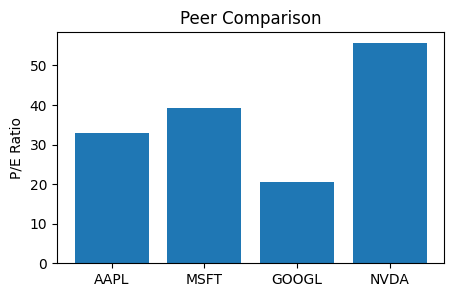

In [13]:

plt.figure(figsize=(5,3))
plt.bar([ticker_symbol] + peers,
        [info.get('trailingPE')] + [yf.Ticker(p).info.get('trailingPE') for p in peers])
plt.ylabel('P/E Ratio')
plt.title('Peer Comparison')
plt.show()


7. Technical Analysis
7.1 Indicator Calculation

In [14]:
# Prepare Series for pandas_ta

# Assuming `data` is your DataFrame, get Series
close = data['Close'] if 'Close' in data else data[('Close', 'AAPL')]
if isinstance(close, pd.DataFrame):
    close = close.squeeze()

high = data['High'] if 'High' in data else data[('High', 'AAPL')]
if isinstance(high, pd.DataFrame):
    high = high.squeeze()

low = data['Low'] if 'Low' in data else data[('Low', 'AAPL')]
if isinstance(low, pd.DataFrame):
    low = low.squeeze()

volume = data['Volume'] if 'Volume' in data else data[('Volume', 'AAPL')]
if isinstance(volume, pd.DataFrame):
    volume = volume.squeeze()
data['EMA_20'] = ta.ema(close, length=20)
data['EMA_50'] = ta.ema(close, length=50)
data['WILLR'] = ta.willr(high, low, close, length=14)
data['RSI'] = ta.rsi(close, length=14)
data['ATR'] = ta.atr(high, low, close, length=14)
stochrsi = ta.stochrsi(close, length=14)
if isinstance(stochrsi, pd.DataFrame):
    data['StochRSI'] = stochrsi.iloc[:, 0]
data['CMO'] = ta.cmo(close, length=14)
kc = ta.kc(high, low, close, length=20)
data['KC_Mid'] = kc['KCLe_20_2.0']
data['KC_Upper'] = kc['KCLU_20_2.0']
adx = ta.adx(high, low, close, length=14)
data['ADX'] = adx['ADX_14']

# Donchian channel
donch = ta.donchian(high=high, low=low, lower_length=20, upper_length=20)
data['donchian_high'] = donch['DCU_20_20']
data['donchian_low'] = donch['DCL_20_20']


KeyError: ('Close', 'AAPL')

7.2 Signal Generation

In [13]:
# RSI-based events
data['RSI_signal'] = 0
data.loc[data['RSI'] < 30, 'RSI_signal'] = 1
data.loc[data['RSI'] > 70, 'RSI_signal'] = -1

# MACD signals
macd = ta.macd(close)
data['MACD'] = macd['MACD_12_26_9']
data['MACD_Signal'] = macd['MACDs_12_26_9']
data['MACD_signal'] = 0
data.loc[(data['MACD'] > data['MACD_Signal']) & (data['MACD'].shift(1) <= data['MACD_Signal'].shift(1)), 'MACD_signal'] = 1
data.loc[(data['MACD'] < data['MACD_Signal']) & (data['MACD'].shift(1) >= data['MACD_Signal'].shift(1)), 'MACD_signal'] = -1


KeyError: 'RSI'

7.3 Visualization
Static

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(close, label='Close')
plt.plot(data['EMA_20'], label='EMA 20')
plt.plot(data['EMA_50'], label='EMA 50')
plt.fill_between(data.index, data['donchian_low'], data['donchian_high'], color='lightgrey', alpha=0.3, label='Donchian Channel')
plt.title(f"{ticker_symbol} - Price, EMA, Donchian")
plt.legend()
plt.show()


Interactive

In [ ]:
fig = go.Figure()
fig.add_trace(go.Candlestick(x=data.index, open=data['Open'], high=high, low=low, close=close, name='Candlestick'))
fig.add_trace(go.Scatter(x=data.index, y=data['EMA_20'], name='EMA 20'))
fig.add_trace(go.Scatter(x=data.index, y=data['donchian_high'], name='Donchian High'))
fig.add_trace(go.Scatter(x=data.index, y=data['donchian_low'], name='Donchian Low'))
fig.update_layout(title=f"{ticker_symbol} Candlestick & Channels")
fig.show()


8. Optional: News Sentiment (LLM/NLP)

In [ ]:
classifier = pipeline('sentiment-analysis')
news = [
    "Apple launches new product.",
    "Apple faces supply chain concerns.",
]
sentiments = classifier(news)
print(pd.DataFrame({"Headline": news, "Sentiment": [s['label'] for s in sentiments], "Score": [s['score'] for s in sentiments]}))
